In [163]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import glob
import seaborn as sns
import os
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')

In [172]:
class AudioProcessing:
    def __init__(self, audio_filepath_snoring, audio_filepath_non_snoring):
        self.audio_filepath_snoring = audio_filepath_snoring
        self.audio_filepath_non_snoring = audio_filepath_non_snoring

    def load_dataFrame(self, audio_filepath, label, class_id):
        file_pattern = '*.wav'
        file_names = []
        labels = []
        file_paths = glob.glob(os.path.join(audio_filepath, '**', file_pattern), recursive=True)

        for file_path in file_paths:
            file_name = os.path.basename(file_path)
            file_names.append(file_name)
            labels.append(label)

        data = {'audio': file_names, 'Labels': labels, "class_id": class_id}
        df = pd.DataFrame(data)

        return df

    def extract_mfcc_features(self, audio_data, sample_rate, num_mfcc=20, num_filter_banks=26):
        filter_banks = librosa.filters.mel(sr=sample_rate, n_fft=2048, n_mels=num_filter_banks)
        filter_banks_features = np.dot(filter_banks, np.abs(librosa.stft(audio_data))**2.0)

        mfcc = librosa.feature.mfcc(S=librosa.power_to_db(filter_banks_features), n_mfcc=num_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        mfcc_features = np.concatenate((mfcc_mean, mfcc_std))
        return mfcc_features

    def process_snoring(self):
        df_snoring = self.load_dataFrame(self.audio_filepath_snoring, "snoring", 1)
        audio_data_snoring = []
        sample_rate_snoring = []
        features_snoring=[]

        for index, row in df_snoring.iterrows():
            audio_file = row['audio']
            audio_file_path = os.path.join(self.audio_filepath_snoring, audio_file)
            audio_data, sample_rate = librosa.load(audio_file_path)
            audio_data_snoring.append(audio_data)
            sample_rate_snoring.append(sample_rate)
            
            # Extract MFCC features
            mfcc_features = self.extract_mfcc_features(audio_data, sample_rate)
            features_snoring.append(mfcc_features)

        df_snoring['Audio_Data'] = audio_data_snoring
        df_snoring['Sample_Rate'] = sample_rate_snoring
        df_snoring['Features'] = features_snoring

        # Display audio
        display(Audio(audio_data_snoring[0], rate=sample_rate_snoring[0]))

        # Wave plot for snoring
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio_data_snoring[0], alpha=0.25)
        plt.title("Wave Plot for Snoring")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.show()


        # Plot the FFT
        plt.figure(figsize=(8, 4))
        fft = np.fft.fft(audio_data_snoring[0])
        magnitude = np.abs(fft)
        frequency = np.linspace(0, sample_rate_snoring, len(magnitude))
        #half_spectrum = fft[:int(len(fft) / 2)]
        #half_frequency = frequency[:int(len(fft)/2)]
        plt.plot(frequency[:len(frequency) // 2], magnitude[:len(frequency) // 2])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title('FFT of Snoring Audio')
        plt.show()

        # Plot the spectrogram
        plt.figure(figsize=(10, 4))
        spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data_snoring[0])), ref=np.max)
        librosa.display.specshow(spectrogram, sr=sample_rate_snoring[0], x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram of Snoring Audio')
        plt.show()

        # Plot MFFC
        features_snoring = np.array(features_snoring)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(features_snoring.T, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('MFCC Features')
        plt.xlabel('Time')
        plt.ylabel('MFCC Coefficients')
        plt.show()

        df_snoring.to_csv('../dataset/csv/snoring_data.csv', index=False)

        return df_snoring


    def process_non_snoring(self):
        df_non_snoring = self.load_dataFrame(self.audio_filepath_non_snoring, "non-snoring", 0)
        audio_data_non_snoring = []
        sample_rate_non_snoring = []
        features_non_snoring = []
        

        for index, row in df_non_snoring.iterrows():
            audio_file = row['audio']
            audio_file_path = os.path.join(self.audio_filepath_non_snoring, audio_file)
            audio_data, sample_rate = librosa.load(audio_file_path)
            audio_data_non_snoring.append(audio_data)
            sample_rate_non_snoring.append(sample_rate)

            # Extract MFCC features
            mfcc_features = self.extract_mfcc_features(audio_data, sample_rate)
            features_non_snoring.append(mfcc_features)

        df_non_snoring['Audio_Data'] = audio_data_non_snoring
        df_non_snoring['Sample_Rate'] = sample_rate_non_snoring
        df_non_snoring['Features'] = features_non_snoring

        display(Audio(audio_data_non_snoring[99], rate=sample_rate_non_snoring[99]))

        # Waveform plot for non snoring
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio_data_non_snoring[99], alpha=0.25)
        plt.title("Wave plot for non-snoring")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.show()

        # FFT for non-snoring Audio
        plt.figure(figsize=(8, 4))
        fft = np.fft.fft(audio_data_non_snoring[99])
        magnitude = np.abs(fft)
        frequency = np.linspace(0, sample_rate_non_snoring, len(magnitude))
        plt.plot(frequency[:len(frequency) // 2], magnitude[:len(frequency) // 2])

        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title('FFT of Non Snoring Audio')
        plt.show()

        # Plot the spectrogram
        plt.figure(figsize=(10, 4))
        spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data_non_snoring[99])), ref=np.max)
        librosa.display.specshow(spectrogram, sr=sample_rate_non_snoring[0], x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram of Non-Snoring Audio')
        plt.show()

        features_non_snoring = np.array(features_non_snoring)

        # Plot MFCC
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(features_non_snoring.T, x_axis='time')
        plt.colorbar(format='%+2.0f dB')
        plt.title('MFCC Features')
        plt.xlabel('Time')
        plt.ylabel('MFCC Coefficients')
        plt.show()

        df_non_snoring.to_csv('../dataset/csv/non_snoring_data.csv', index=False)

        return df_non_snoring

    def merge_dataframe(self):
        df_snoring = pd.read_csv("../dataset/csv/snoring_data.csv")
        df_non_snoring = pd.read_csv("../dataset/csv/non_snoring_data.csv")
        df = pd.concat([df_snoring, df_non_snoring])

        df['Features'] = df['Features'].apply(lambda x: np.array(x.strip('[]').split()).astype(float))

        # Prepare df for model building
        df.drop(columns=['audio', 'Labels', 'Audio_Data', 'Sample_Rate'], inplace=True)
        return df

    def train_model(self):
        df = self.merge_dataframe()
        X = df['Features'].to_list()
        y = df['class_id']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Convert X_train and X_test to numpy arrays
        X_train = np.array(X_train)
        X_test = np.array(X_test)

        # Reshape X_train and X_test to 2D arrays (required for StandardScaler)
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)

        # Initialize standard scaler
        sc_X = StandardScaler()
        X_train = sc_X.fit_transform(X_train)
        X_test = sc_X.fit_transform(X_test)

        classifier = SVC(kernel='rbf')
        classifier.fit(X_train, y_train)

        y_pred = classifier.predict(X_test)
        accuracy = metrics.accuracy_score(y_test, y_pred)
        return y_pred, accuracy

In [173]:
audio_filepath_snoring = '../dataset/1/'
audio_filepath_non_snoring = '../dataset/0/'
preprocessing = AudioProcessing(audio_filepath_snoring, audio_filepath_non_snoring)

### Process Snoring Audio

The `process_snoring` method loads and processes the snoring audio files.

#### Steps:
1. Load the snoring audio files and create an empty list for audio data, sample rates, and features.
2. Iterate over each snoring audio file:
   - Load the audio data and sample rate using librosa.
   - Append the audio data and sample rate to their respective lists.
   - Extract MFCC features from the audio data and append them to the features list.
3. Create columns in the dataframe to store the audio data, sample rates, and features.
4. Display the audio waveform, FFT, spectrogram, and MFCC features for a selected snoring audio file.
5. Return the dataframe containing the snoring audio information.

**Inputs:**
- `audio_filepath_snoring`: Path to the directory containing snoring audio files.

**Outputs:**
- `df_snoring`: DataFrame containing information about the snoring audio files.

### Process Non-Snoring Audio

The `process_non_snoring` method loads and processes the non-snoring audio files.

#### Steps:
1. Load the non-snoring audio files and create an empty list for audio data, sample rates, and features.
2. Iterate over each non-snoring audio file:
   - Load the audio data and sample rate using librosa.
   - Append the audio data and sample rate to their respective lists.
   - Extract MFCC features from the audio data and append them to the features list.
3. Create columns in the dataframe to store the audio data, sample rates, and features.
4. Display the audio waveform, FFT, spectrogram, and MFCC features for a selected non-snoring audio file.
5. Return the dataframe containing the non-snoring audio information.

**Inputs:**
- `audio_filepath_non_snoring`: Path to the directory containing non-snoring audio files.

**Outputs:**
- `df_non_snoring`: DataFrame containing information about the non-snoring audio files.

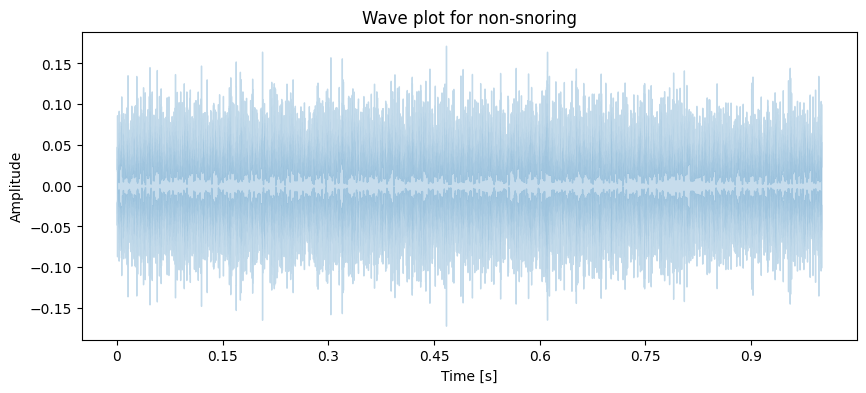

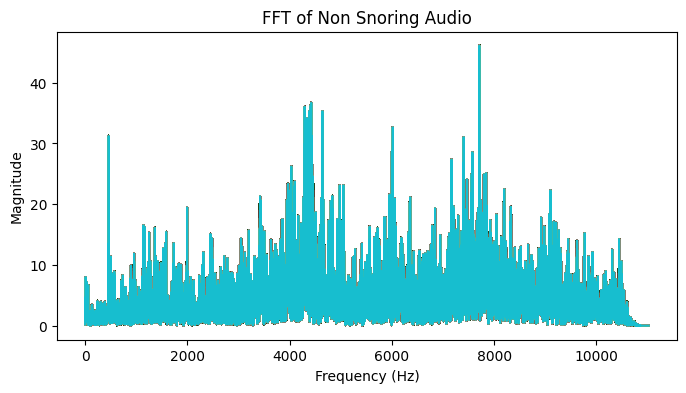

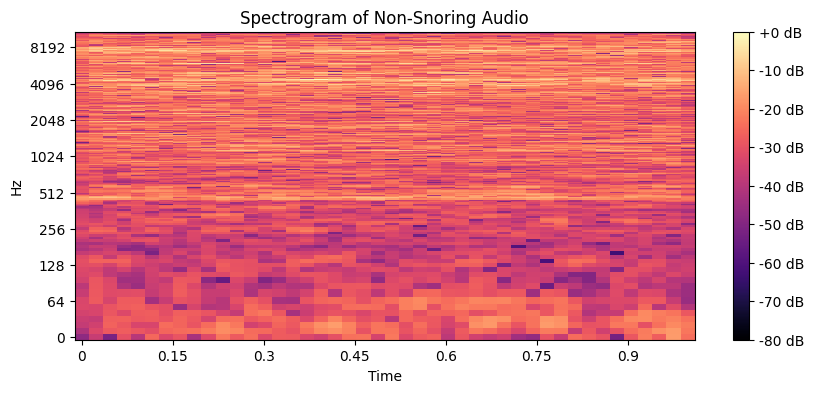

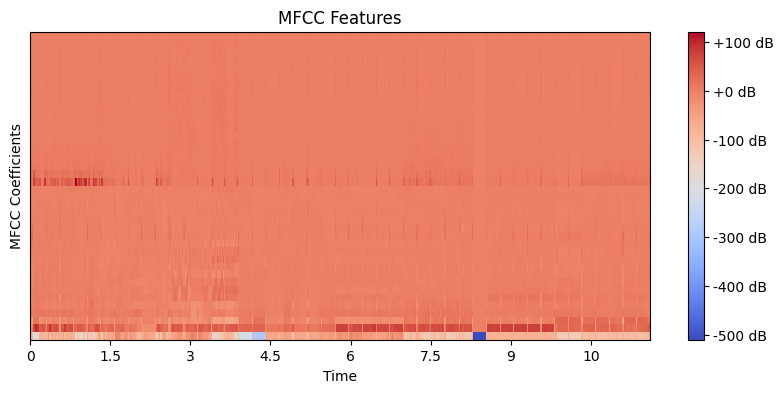

,audio,Labels,class_id,Audio_Data,Sample_Rate,Features
0,0_0.wav,non-snoring,0,"[-0.00058085367, -0.00050609757, -0.0001397804...",22050,"[-98.32893, 21.42574, -28.066767, 2.5579772, -..."
1,0_1.wav,non-snoring,0,"[0.003066753, 0.0017055022, -0.0022731116, -0....",22050,"[-65.30684, -12.796179, -32.80339, 17.84969, -..."
2,0_10.wav,non-snoring,0,"[0.0915068, 0.09224098, -0.042199746, -0.08157...",22050,"[-85.972534, -7.2961926, -44.751266, 7.5795803..."
3,0_100.wav,non-snoring,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,"[-204.44257, 71.9476, 10.654166, 8.464132, 6.2..."
4,0_101.wav,non-snoring,0,"[-0.00883612, -0.022794187, -0.026883185, -0.0...",22050,"[-179.78432, 94.90889, 21.97803, 11.744449, 10..."
...,...,...,...,...,...,...
495,0_95.wav,non-snoring,0,"[0.024252638, -0.014674451, -0.015143929, -0.0...",22050,"[-100.051544, 29.781397, 32.148464, 6.280559, ..."
496,0_96.wav,non-snoring,0,"[0.018210696, 0.031199241, 0.021137957, 0.0086...",22050,"[-90.129715, 33.406216, 30.923891, 3.6242592, ..."
497,0_97.wav,non-snoring,0,"[-0.022554792, -0.010832615, 0.004788533, -0.0...",22050,"[-105.66708, 33.880173, 31.081709, 6.383206, 2..."
498,0_98.wav,non-snoring,0,"[0.024879623, 0.040676795, 0.030412303, 0.0390...",22050,"[-83.99695, 37.839565, 25.000507, 0.9402263, -..."


In [54]:
preprocessing.process_non_snoring()

### Concatenate df_non_snoring.csv and df_snoring.csv


In [174]:
df = preprocessing.merge_dataframe()

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 499
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class_id  1000 non-null   int64 
 1   Features  1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


In [177]:
df.head()

,class_id,Features
0,1,"[-88.047279, 26.810228, 4.7494321, -0.13425189..."
1,1,"[-154.535, 27.052277, -10.878284, -8.543524, -..."
2,1,"[-118.14583, 29.601423, 7.5992703, 1.3168781, ..."
3,1,"[-166.15884, 43.78569, -1.4785812, 10.815608, ..."
4,1,"[-106.421196, 56.687332, -12.594318, 10.966558..."


In [175]:
preprocessing.train_model()

(array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 1], dtype=int64),
 0.99)